<a href="https://colab.research.google.com/github/rishikam23/TOPSIS-for-pre-trained-models/blob/main/TOPSIS_for_pre_trained_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install datasets

In [18]:
import os
WORKING_DIR = r"C:\Users\RISHIKA MATHUR\Desktop\Thapar VI sem\Predictive Analysis\topsis"
if not os.path.exists(WORKING_DIR):
    os.makedirs(WORKING_DIR)

In [19]:
import time
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from datasets import load_dataset

#Loading STS Benchmark dataset
dataset=load_dataset("stsb_multi_mt",name="en",split="train")
sentence_pairs=list(zip(dataset["sentence1"],dataset["sentence2"],dataset["similarity_score"]))

#Normalization
max_score=max(dataset["similarity_score"])
sentence_pairs=[(s1, s2, score / max_score) for s1, s2, score in sentence_pairs]

df_pairs=pd.DataFrame(sentence_pairs,columns=["Sentence1","Sentence2","Human Score"])

#Defining models
models={"MiniLM-L6":"sentence-transformers/paraphrase-MiniLM-L6-v2","MiniLM-L12":"sentence-transformers/all-MiniLM-L12-v2",
        "MPNet-Base":"sentence-transformers/paraphrase-mpnet-base-v2","All-MPNet":"sentence-transformers/all-mpnet-base-v2"}
model_size_dict={"MiniLM-L6":22,"MiniLM-L12":33,"MPNet-Base":100,"All-MPNet":110}
results=[]

#Evaluating each model
for model_name,model_path in models.items():
    model=SentenceTransformer(model_path)
    print(f"Evaluating:{model_name}")
    start_time=time.time()
    embeddings1=model.encode(df_pairs["Sentence1"].tolist(),convert_to_tensor=False)
    embeddings2=model.encode(df_pairs["Sentence2"].tolist(),convert_to_tensor=False)
    inf_time=(time.time()-start_time)/len(df_pairs)

    computed_scores=[cosine_similarity([e1],[e2])[0][0] for e1,e2 in zip(embeddings1,embeddings2)]
    corr, _ =pearsonr(computed_scores,df_pairs["Human Score"])
    model_size_mb=model_size_dict.get(model_name.split("/")[-1],50)

    results.append([model_name,corr,inf_time,model_size_mb])

#Saving the csv file
df_results=pd.DataFrame(results, columns=["Model","Correlation","Inference Time","Model Size"])
df_results.to_csv("topsis_input.csv",index=False)
print("Evaluation completed. Data saved to topsis_input.csv")


Evaluating:MiniLM-L6
Evaluating:MiniLM-L12
Evaluating:MPNet-Base
Evaluating:All-MPNet
Evaluation completed. Data saved to topsis_input.csv


In [20]:
from google.colab import files
files.download("/content/topsis_input.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
!python 102203128.py "topsis_input.csv" "0.5,0.3,0.2" "+,-,-" "topsis_result.csv"

Result file saved as 'topsis_result.csv'.


In [25]:
import pandas as pd
from tabulate import tabulate

#Displaying results
df_topsis_results = pd.read_csv("topsis_result.csv")
df_topsis_results = df_topsis_results.sort_values(by="Rank")
print(tabulate(df_topsis_results, headers="keys", tablefmt="pretty"))

+---+------------+--------------------+--------------------+------------+--------------------+------+
|   |   Model    |    Correlation     |   Inference Time   | Model Size |    Topsis Score    | Rank |
+---+------------+--------------------+--------------------+------------+--------------------+------+
| 0 | MiniLM-L6  | 0.8470136838318714 | 0.0190228582320161 |     22     | 0.9728091958885824 |  1   |
| 1 | MiniLM-L12 | 0.8432774106996839 | 0.0372248405497019 |     33     | 0.8434844723551501 |  2   |
| 2 | MPNet-Base | 0.8671197324805402 | 0.1293838268820151 |    100     | 0.0677648914493907 |  3   |
| 3 | All-MPNet  | 0.8580658363697954 | 0.1298294495781477 |    110     | 0.0201429820185125 |  4   |
+---+------------+--------------------+--------------------+------------+--------------------+------+


<ipython-input-26-04c2f8c371e9>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model",y="Topsis Score",data=df_topsis_results,palette="viridis")


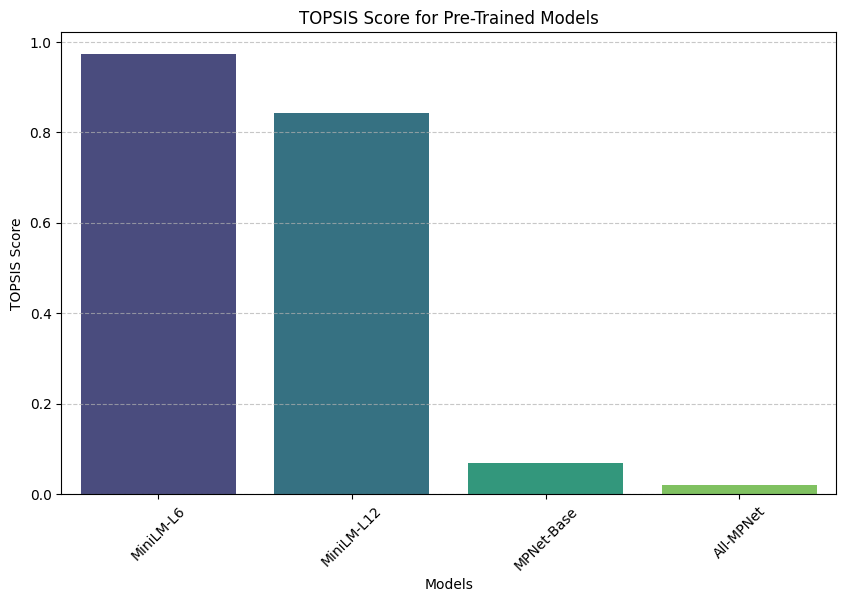

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

#Bar plot for TOPSIS Score
plt.figure(figsize=(10, 6))
sns.barplot(x="Model",y="Topsis Score",data=df_topsis_results,palette="viridis")
plt.xticks(rotation=45)
plt.title("TOPSIS Score for Pre-Trained Models")
plt.ylabel("TOPSIS Score")
plt.xlabel("Models")
plt.grid(axis="y",linestyle="--",alpha=0.7)
plt.show()

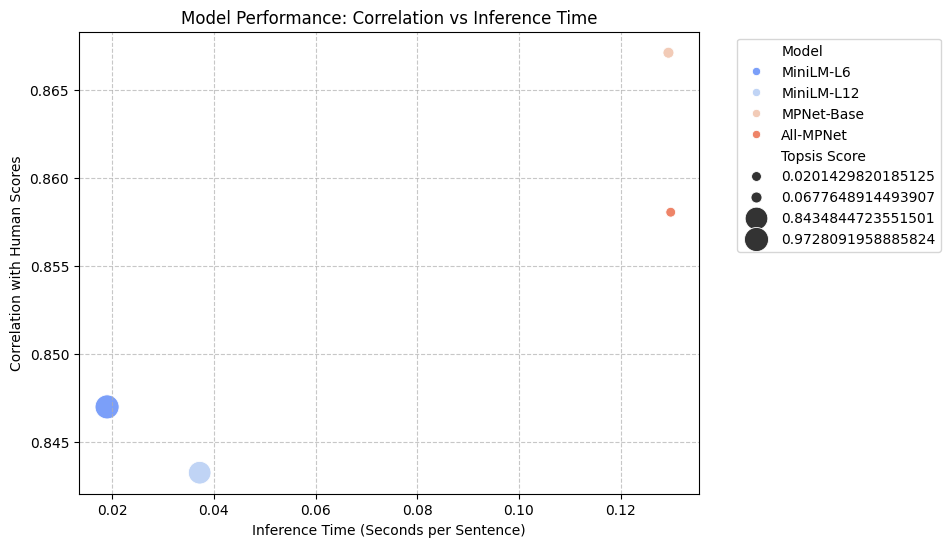

In [27]:
#Comparing models
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_topsis_results,x="Inference Time",y="Correlation",hue="Model",size="Topsis Score",sizes=(50, 300),palette="coolwarm")
plt.title("Model Performance: Correlation vs Inference Time")
plt.xlabel("Inference Time (Seconds per Sentence)")
plt.ylabel("Correlation with Human Scores")
plt.grid(True,linestyle="--",alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1),loc="upper left")
plt.show()

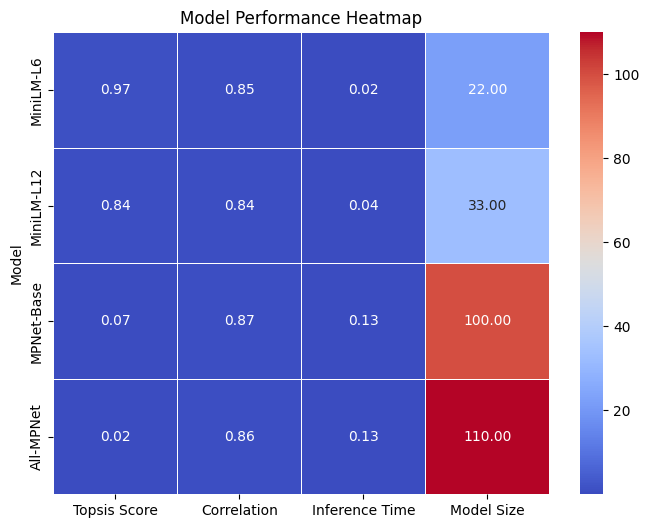

In [29]:
#Overall performance
plt.figure(figsize=(8,6))
df_heatmap=df_topsis_results.set_index("Model")[["Topsis Score","Correlation","Inference Time","Model Size"]]
sns.heatmap(df_heatmap,annot=True,cmap="coolwarm",linewidths=0.5,fmt=".2f")
plt.title("Model Performance Heatmap")
plt.show()